# Analisis Database Sakila

Pada project kali ini dilakukan analisis database sakila dari mysql. Analisis berfokus ke store dan staff. Tujuan utamanya adalah melihat performa dari store dan staff.

In [2]:
# Manipulasi data
import numpy as np
import pandas as pd

# Visualiasai -> dipilih karena lebih nyaman dan bisa langsung melakukan preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# connect ke DB MySql
import mysql.connector

In [2]:
sakiladb = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    passwd = '$29iBnu!',
    database = 'sakila',
)

In [3]:
mycursor = sakiladb.cursor()

In [4]:
def get_data_df(query):
    global mycursor
    mycursor.execute(query)
    result = mycursor.fetchall()
    temp = pd.DataFrame(data=result, columns=mycursor.column_names)
    
    return temp

# Get Data

## Address Full

In [14]:
address_full = get_data_df(
    '''
    WITH
    address_city as (
        SELECT address_id, address, postal_code ,district, city.city, city.country_id
        FROM address
        LEFT JOIN city
        ON address.city_id = city.city_id
    ),
    address_full as (
        SELECT address_id, address, district, city,  postal_code, country.country
        FROM address_city
        LEFT JOIN country
        ON address_city.country_id = country.country_id
    )
    SELECT  * FROM
    address_full;
    '''
)

In [15]:
address_full.head()

,address_id,address,district,city,postal_code,country
0,1,47 MySakila Drive,Alberta,Lethbridge,,Canada
1,2,28 MySQL Boulevard,QLD,Woodridge,,Australia
2,3,23 Workhaven Lane,Alberta,Lethbridge,,Canada
3,4,1411 Lillydale Drive,QLD,Woodridge,,Australia
4,5,1913 Hanoi Way,Nagasaki,Sasebo,35200,Japan


In [16]:
address_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address_id   603 non-null    int64 
 1   address      603 non-null    object
 2   district     603 non-null    object
 3   city         603 non-null    object
 4   postal_code  603 non-null    object
 5   country      603 non-null    object
dtypes: int64(1), object(5)
memory usage: 28.4+ KB


## Store

In [19]:
store = get_data_df(
    '''
    SELECT  * FROM
    store;
    '''
)

In [20]:
store

,store_id,manager_staff_id,address_id,last_update
0,1,1,1,2006-02-15 04:57:12
1,2,2,2,2006-02-15 04:57:12


## Staff

In [42]:
staff = get_data_df(
    '''
    SELECT  * FROM
    staff;
    '''
)

In [43]:
staff

,staff_id,first_name,last_name,address_id,picture,email,store_id,active,username,password,last_update
0,1,Mike,Hillyer,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Mike.Hillyer@sakilastaff.com,1,1,Mike,8cb2237d0679ca88db6464eac60da96345513964,2006-02-15 03:57:16
1,2,Jon,Stephens,4,None,Jon.Stephens@sakilastaff.com,2,1,Jon,None,2006-02-15 03:57:16


### Store Address & Staff

In [31]:
store_full_info = pd.merge(left = store, left_on = 'address_id', 
                           right = address_full, right_on = 'address_id' )

In [32]:
store_full_info = pd.merge(left = store_full_info, left_on = 'manager_staff_id', 
                           right = staff, right_on = 'staff_id' )

In [33]:
store_full_info.columns

Index(['store_id_x', 'manager_staff_id', 'address_id_x', 'last_update_x',
       'address', 'district', 'city', 'postal_code', 'country', 'staff_id',
       'first_name', 'last_name', 'address_id_y', 'picture', 'email',
       'store_id_y', 'active', 'username', 'password', 'last_update_y'],
      dtype='object')

In [34]:
store_full_info = store_full_info[['store_id_x', 'manager_staff_id', 'address_id_x',
       'address', 'district', 'city', 'country', 
       'first_name', 'last_name'
]]

In [35]:
store_full_info.columns = ['store_id', 'manager_staff_id', 'address_id',
       'address', 'district', 'city', 'country', 
       'first_name', 'last_name']

In [36]:
store_full_info

,store_id,manager_staff_id,address_id,address,district,city,country,first_name,last_name
0,1,1,1,47 MySakila Drive,Alberta,Lethbridge,Canada,Mike,Hillyer
1,2,2,2,28 MySQL Boulevard,QLD,Woodridge,Australia,Jon,Stephens


### Staff Address

In [37]:
staff_address = pd.merge(left = staff, left_on = 'address_id', 
                           right = address_full, right_on = 'address_id' )

In [39]:
staff_address.drop(['postal_code'],axis=1, inplace=True)

In [40]:
staff_address

,staff_id,first_name,last_name,address_id,picture,email,store_id,active,username,password,last_update,address,district,city,country
0,1,Mike,Hillyer,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Mike.Hillyer@sakilastaff.com,1,1,Mike,8cb2237d0679ca88db6464eac60da96345513964,2006-02-15 03:57:16,23 Workhaven Lane,Alberta,Lethbridge,Canada
1,2,Jon,Stephens,4,None,Jon.Stephens@sakilastaff.com,2,1,Jon,None,2006-02-15 03:57:16,1411 Lillydale Drive,QLD,Woodridge,Australia


## Inventory and Film

In [50]:
inv_film = get_data_df(
    '''
WITH 
    film_language AS(
        SELECT film_id, title, release_year, film.language_id,
               language.name as language, rental_duration, rental_rate, 
               length, replacement_cost, rating, special_features FROM film
        JOIN language
        ON film.language_id = language.language_id
    )
SELECT  * FROM
inventory
LEFT JOIN film_language
ON inventory.film_id = film_language.film_id;
    '''
)

In [51]:
inv_film.head()

,inventory_id,film_id,store_id,last_update,film_id,title,release_year,language_id,language,rental_duration,rental_rate,length,replacement_cost,rating,special_features
0,1,1,1,2006-02-15 05:09:17,1,ACADEMY DINOSAUR,2006,1,English,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}"
1,2,1,1,2006-02-15 05:09:17,1,ACADEMY DINOSAUR,2006,1,English,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}"
2,3,1,1,2006-02-15 05:09:17,1,ACADEMY DINOSAUR,2006,1,English,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}"
3,4,1,1,2006-02-15 05:09:17,1,ACADEMY DINOSAUR,2006,1,English,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}"
4,5,1,2,2006-02-15 05:09:17,1,ACADEMY DINOSAUR,2006,1,English,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}"


## Customer

### Customer Address

In [55]:
customer_address = get_data_df(
    '''
    WITH
    address_city as (
        SELECT address_id, address, postal_code ,district, city.city, city.country_id
        FROM address
        LEFT JOIN city
        ON address.city_id = city.city_id
    ),
    address_full as (
        SELECT address_id, address, district, city,  postal_code, country.country
        FROM address_city
        LEFT JOIN country
        ON address_city.country_id = country.country_id
    )
    SELECT  customer_id, store_id, first_name,  last_name, address, postal_code  ,district, city, country
    FROM customer
    LEFT JOIN address_full
    ON customer.address_id = address_full.address_id;
    '''
)

In [56]:
customer_address.head()

,customer_id,store_id,first_name,last_name,address,postal_code,district,city,country
0,1,1,MARY,SMITH,1913 Hanoi Way,35200,Nagasaki,Sasebo,Japan
1,2,1,PATRICIA,JOHNSON,1121 Loja Avenue,17886,California,San Bernardino,United States
2,3,1,LINDA,WILLIAMS,692 Joliet Street,83579,Attika,Athenai,Greece
3,4,2,BARBARA,JONES,1566 Inegl Manor,53561,Mandalay,Myingyan,Myanmar
4,5,1,ELIZABETH,BROWN,53 Idfu Parkway,42399,Nantou,Nantou,Taiwan


## Rental

In [57]:
rental = get_data_df('SELECT * FROM rental;')

In [58]:
rental.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53


In [60]:
rental_inventory = rental.merge(inv_film, left_on='inventory_id', right_on='inventory_id',how='left')

In [61]:
rental_inventory.columns

Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update_x', 'film_id', 'store_id',
       'last_update_y', 'film_id', 'title', 'release_year', 'language_id',
       'language', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features'],
      dtype='object')

In [62]:
rental_inventory.drop(['last_update_y','last_update_x'],axis=1)

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,film_id,store_id,film_id,title,release_year,language_id,language,rental_duration,rental_rate,length,replacement_cost,rating,special_features
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,80,1,80,BLANKET BEVERLY,2006,1,English,7,2.99,148,21.99,G,{Trailers}
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,333,2,333,FREAKY POCUS,2006,1,English,7,2.99,126,16.99,R,"{Trailers, Behind the Scenes}"
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,373,2,373,GRADUATE LORD,2006,1,English,7,2.99,156,14.99,G,"{Trailers, Behind the Scenes}"
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,535,1,535,LOVE SUICIDES,2006,1,English,6,0.99,181,21.99,R,"{Trailers, Behind the Scenes}"
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,450,2,450,IDOLS SNATCHERS,2006,1,English,5,2.99,84,29.99,NC-17,{Trailers}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,16045,2005-08-23 22:25:26,772,14,2005-08-25 23:54:26,1,168,1,168,COMANCHEROS ENEMY,2006,1,English,5,0.99,67,23.99,R,"{Trailers, Behind the Scenes}"
16040,16046,2005-08-23 22:26:47,4364,74,2005-08-27 18:02:47,2,951,2,951,VOYAGE LEGALLY,2006,1,English,6,0.99,78,28.99,PG-13,"{Commentaries, Behind the Scenes}"
16041,16047,2005-08-23 22:42:48,2088,114,2005-08-25 02:48:48,2,452,2,452,ILLUSION AMELIE,2006,1,English,4,0.99,122,15.99,R,"{Commentaries, Behind the Scenes}"
16042,16048,2005-08-23 22:43:07,2019,103,2005-08-31 21:33:07,1,439,1,439,HUNCHBACK IMPOSSIBLE,2006,1,English,4,4.99,151,28.99,PG-13,"{Deleted Scenes, Trailers}"


In [68]:
payment = get_data_df('SELECT * FROM payment;')

In [80]:
rental_inventory_payment = pd.merge(left=rental_inventory, left_on='rental_id',
                                    right=payment, right_on='rental_id',how='outer',copy=False,suffixes=('','_payment'))

# Save Data

In [84]:
need_to_save = [store_full_info,staff_address,store_full_info,customer_address,rental_inventory_payment,inv_film]
file_name = ['store_full_info','staff_address','store_full_info','customer_address','rental_inventory_payment','inv_film']

In [85]:
for file,df in zip(file_name, need_to_save):
    df.to_csv('data/'+file+'.csv')

# Analisis

In [3]:
color_store_1 = '#FF7F0E'
color_store_2 = '#9467BD'

In [4]:
store = pd.read_csv('data/store_full_info.csv',index_col=0)
staff = pd.read_csv('data/staff_address.csv',index_col=0)
rental = pd.read_csv('data/rental_inventory_payment.csv',index_col=0)

# Store

In [5]:
store

,store_id,manager_staff_id,address_id,address,district,city,country,first_name,last_name
0,1,1,1,47 MySakila Drive,Alberta,Lethbridge,Canada,Mike,Hillyer
1,2,2,2,28 MySQL Boulevard,QLD,Woodridge,Australia,Jon,Stephens


## Basic Info

* Terdapat 2 Toko Sakila DVD Rental
* Terletak di Canada dan Australia
* Manajer dari toko Canada adalah Mike Hillyer dan manajer dari toko Australia adalah Jon Stephens

## Berapa banyak staff di setiap toko?

In [6]:
staff.head()

,staff_id,first_name,last_name,address_id,picture,email,store_id,active,username,password,last_update,address,district,city,country
0,1,Mike,Hillyer,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Mike.Hillyer@sakilastaff.com,1,1,Mike,8cb2237d0679ca88db6464eac60da96345513964,2006-02-15 03:57:16,23 Workhaven Lane,Alberta,Lethbridge,Canada
1,2,Jon,Stephens,4,NaN,Jon.Stephens@sakilastaff.com,2,1,Jon,NaN,2006-02-15 03:57:16,1411 Lillydale Drive,QLD,Woodridge,Australia


* Ternyata setiap toko hanya memiliki 1 karyawan
* Karyawan tersebut juga merupakan manajer
* Kemungkinan Toko ini merupakan one man store
* Setiap karyawan berada di negara dan kota yang sama dengan storenya

---

## Sales

In [7]:
rental.isna().sum()

rental_id                5
rental_date              5
inventory_id             5
customer_id              5
return_date            188
staff_id                 5
last_update_x            5
film_id                  5
store_id                 5
last_update_y            5
film_id.1                5
title                    5
release_year             5
language_id              5
language                 5
rental_duration          5
rental_rate              5
length                   5
replacement_cost         5
rating                   5
special_features         5
payment_id               0
customer_id_payment      0
staff_id_payment         0
amount                   0
payment_date             0
last_update              0
dtype: int64

Ada keadaan yang aneh, dimana rental_id ada yang null tetapi payment ada tidak ada yang null

### Berapa total sales dari toko sakila?

In [8]:
rental['amount'].sum()

67416.51000000001

In [9]:
rental[rental['rental_id'].isna()]

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update_x,film_id,store_id,last_update_y,...,length,replacement_cost,rating,special_features,payment_id,customer_id_payment,staff_id_payment,amount,payment_date,last_update
16044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,424,16,1,1.99,2005-06-18 04:56:12,2006-02-15 22:12:32
16045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7011,259,2,1.99,2005-08-23 06:13:16,2006-02-15 22:14:58
16046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10840,401,1,0.99,2005-07-12 06:26:10,2006-02-15 22:17:49
16047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14675,546,1,3.99,2005-07-30 21:16:20,2006-02-15 22:21:38
16048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15458,577,2,0.99,2005-05-27 00:46:39,2006-02-15 22:22:32


Tidak ada data rental tetapi ada payment masuk, mungkin untuk sementara tidak terlalu masalah.

### Bagaimana penjualan dari kedua toko?

In [10]:
sales_per_store = rental.groupby('store_id').sum()['amount']

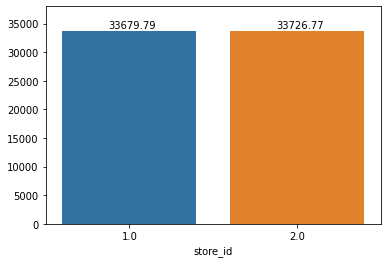

In [11]:
sns.barplot(x=sales_per_store.index, y=sales_per_store.values)
plt.annotate(sales_per_store[1],(-0.125,sales_per_store[1]+500))
plt.annotate(f"{sales_per_store[2]:.2f}",(0.875,sales_per_store[2]+500))
plt.ylim([0,38000])
plt.show()

Jumlah penjualan per toko tidak terlalu jauh.

### Bagaimana penjualan per hari dari toko sakila?

In [12]:
rental[['rental_date','payment_date']]

,rental_date,payment_date
0,2005-05-24 22:53:30,2005-05-24 22:53:30
1,2005-05-24 22:54:33,2005-05-24 22:54:33
2,2005-05-24 23:03:39,2005-05-24 23:03:39
3,2005-05-24 23:04:41,2005-05-24 23:04:41
4,2005-05-24 23:05:21,2005-05-24 23:05:21
...,...,...
16044,NaN,2005-06-18 04:56:12
16045,NaN,2005-08-23 06:13:16
16046,NaN,2005-07-12 06:26:10
16047,NaN,2005-07-30 21:16:20


rental_date == payment_date\
berarti pembayaran dilakukan ketika meminjam, bukan mengembalikan

In [13]:
pay_date = pd.to_datetime(rental['payment_date'])

In [14]:
def get_yyyy_mm_dd(val):
    return str(val.year)+'-'+str(val.month)+'-'+str(val.day)

In [15]:
rental['payment_date'] = pay_date.apply(get_yyyy_mm_dd)

In [16]:
sales_per_day = rental.groupby('payment_date').sum()['amount']

In [17]:
dummy_date_idx = pd.date_range('2005-5-24', '2006-2-14')

In [18]:
sales_per_day.index = pd.DatetimeIndex(sales_per_day.index)

In [19]:
dummy_date_sales = sales_per_day.reindex(dummy_date_idx, fill_value=0)

In [20]:
max_sales_id = dummy_date_sales.argmax()

In [21]:
max_sales_val = dummy_date_sales[max_sales_id]

In [22]:
max_sales_date = dummy_date_sales.index[max_sales_id]

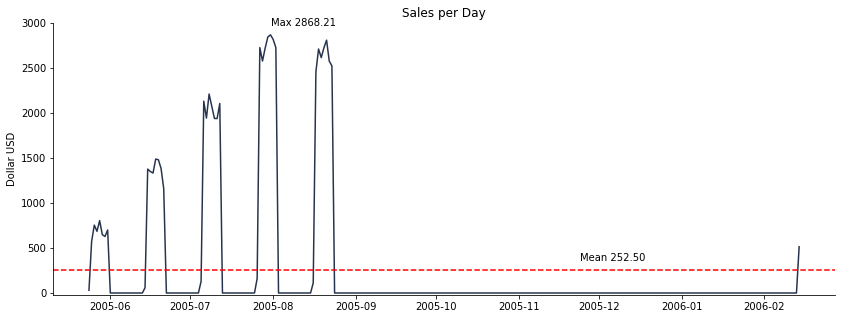

In [23]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,5)
sns.lineplot(x=dummy_date_sales.index, y=dummy_date_sales.values,ax=ax,color='#27344D')
ax.axhline(y=dummy_date_sales.mean(), color='red', linestyle='--')
ax.annotate(f'Mean {dummy_date_sales.mean():.2f}',(pd.to_datetime('2005-11-24'),dummy_date_sales.mean()+100))
ax.annotate(f'Max {max_sales_val:.2f}',(max_sales_date,max_sales_val+100))
ax.set_title('Sales per Day')
ax.set_ylim([-20,3000])
ax.set_ylabel('Dollar USD')
sns.despine()
plt.show()

Pola penjualan pada Toko Sakila cukup unik karena hanya ada transaksi di beberapa periode waktu tertentu saja. Ini membuat rata-rata penjualan menjadi rendah. Mungkin saat tidak terjadi transaksi, memang kedua toko tidak buka.

Penjualan tertinggi Toko Sakila terjadi pada tanggal 2005-07-31

In [24]:
sales_per_day_store = rental.groupby(['store_id','payment_date']).sum()['amount']

In [25]:
sales_per_day_store_1 = sales_per_day_store[1]
sales_per_day_store_2 = sales_per_day_store[2]

dummy_date_idx = pd.date_range('2005-5-24', '2006-2-14')
sales_per_day_store_1.index = pd.DatetimeIndex(sales_per_day_store_1.index)
sales_per_day_store_2.index = pd.DatetimeIndex(sales_per_day_store_2.index)

dummy_sales_per_day_store_1 = sales_per_day_store_1.reindex(dummy_date_idx, fill_value=0)
dummy_sales_per_day_store_2 = sales_per_day_store_2.reindex(dummy_date_idx, fill_value=0)

### Apakah ada perbedaan penjualan antar toko?

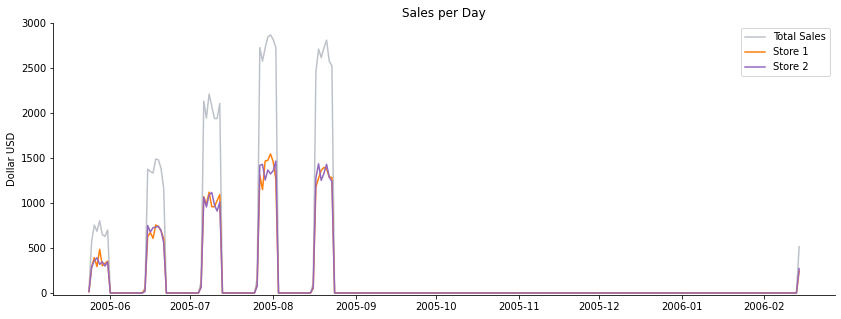

In [26]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,5)

sns.lineplot(x=dummy_date_sales.index, y=dummy_date_sales.values,ax=ax,color='#27344D',alpha=0.3,label='Total Sales')
sns.lineplot(x=dummy_sales_per_day_store_1.index, y=dummy_sales_per_day_store_1.values,ax=ax,color='#FF7F0E',label='Store 1')
sns.lineplot(x=dummy_sales_per_day_store_2.index, y=dummy_sales_per_day_store_2.values,ax=ax,color='#9467BD',label='Store 2')

ax.set_title('Sales per Day')
ax.set_ylim([-20,3000])
ax.set_ylabel('Dollar USD')
sns.despine()
plt.show()

Secara kasat mata dapat dilihat bahwa penjualan per hari antara toko 1 dan 2 tidak terlihat jauh berbeda.

In [27]:
print('Toko 1')
print("Tanggal penjualan tertinggi\t: ",sales_per_day_store_1.index[sales_per_day_store_1.argmax()])
print("Nilai penjualan tertinggi\t: ",sales_per_day_store_1.values[sales_per_day_store_1.argmax()])

Toko 1
Tanggal penjualan tertinggi	:  2005-07-31 00:00:00
Nilai penjualan tertinggi	:  1545.46


In [28]:
print('Toko 2')
print("Tanggal penjualan tertinggi\t: ",sales_per_day_store_2.index[sales_per_day_store_2.argmax()])
print("Nilai penjualan tertinggi\t: ",sales_per_day_store_2.values[sales_per_day_store_2.argmax()])

Toko 2
Tanggal penjualan tertinggi	:  2005-08-02 00:00:00
Nilai penjualan tertinggi	:  1465.5700000000002


Penjualan tertinggi pada Toko 1 terjadi di tanggal 2005-07-31, sementara pada Toko 2 terjadi di tanggal 2005-08-02. Dengan jumlah terpaut hampir 100 Dollar USD

### Bagaimana penjualan dari toko 1 dan 2?

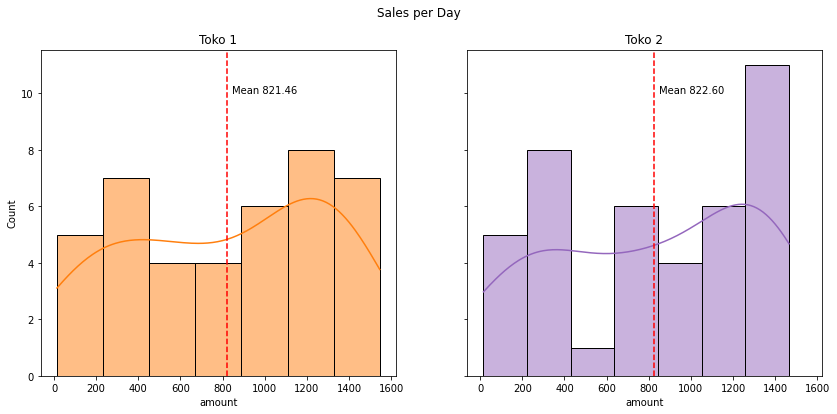

In [29]:
fig, ax = plt.subplots(1,2,sharey=True, sharex=True)
fig.set_size_inches((14,6))

ax[0].set_title('Toko 1')
sns.histplot(sales_per_day_store_1,ax=ax[0],kde=True,color='#FF7F0E')
ax[0].axvline(sales_per_day_store_1.mean(), color='red', linestyle='--')
ax[0].annotate(f"Mean {sales_per_day_store_1.mean():.2f}",(sales_per_day_store_1.mean()+25,10))

ax[1].set_title('Toko 2')
sns.histplot(sales_per_day_store_2,ax=ax[1],kde=True,color='#9467BD')
ax[1].axvline(sales_per_day_store_2.mean(), color='red', linestyle='--')
ax[1].annotate(f"Mean {sales_per_day_store_2.mean():.2f}",(sales_per_day_store_2.mean()+25,10))
plt.suptitle('Sales per Day')
plt.show()

Dapat dilihat bahwa distribusi dari 2 toko tidak normal.\
Sehingga untuk pengujian rerata penjualan perharinya menggunakan Mann-Whitneyu Test

Asumsi : Penjualan 0 tidak dimasukkan, karena tanggalnya terjadi di setiap toko. Mungkin memang ada penutupan berkala.

In [30]:
from scipy.stats import mannwhitneyu

In [31]:
stats, pval = mannwhitneyu(sales_per_day_store_1,
                           sales_per_day_store_2,
                           alternative='two-sided')

In [32]:
pval <= 0.05

False

Ternyata toko 1 dan 2 memiliki rerata penjualan perhari yang sama.

Dari eksplorasi penjualan toko sakila, dapat diketahui beberapa informasi:
* Total penjualan Toko Sakila adalah 67.416 Dollar (USD), pada rentang 2005-5-24 sampai 2006-2-14
* Total penjualan per toko tidak terlalu beda.
* Toko Sakila tidak buka setiap saat, hanya beberapa rentang waktu tertentu.
* Penjualan tertinggi Toko Sakila terjadi pada tanggal 2005-07-31 dengan nilai 2.868 Dollar (USD)
* Rerata penjualan per hari kedua toko tidak terlalu berbeda.

---

## Waktu

### Bagaimana periode buka dari Toko Sakila?

Setelah melihat ada periode buka dari toko, kami ingin melihat waktu atau hari yang paling sering muncul

In [33]:
day_freq = dict()
for date in sales_per_day.index:
    name = date.day_name()
    if name in day_freq:
        day_freq[name] += 1
    else:
        day_freq[name] = 1

In [34]:
pd.DataFrame(data=day_freq.values(),index=day_freq.keys(),columns=['freq'])

,freq
Tuesday,11
Wednesday,5
Thursday,5
Friday,5
Saturday,5
Sunday,5
Monday,5


Ternyata hari dimana toko paling sering buka adalah hari Selasa

In [35]:
open_prd = list()
start = None
end = None
prev = None
for row in dummy_date_sales.iteritems():
    curr = row
    if curr[-1] != 0 and start is None:
        start = curr  
    elif curr[-1] == 0 and start != None:
        end = prev
        open_prd.append([start[0],end[0]])
        start = None
        end = None
    else:
        prev = curr
        
for i in range(len(open_prd)):
    open_prd[i][-1] = open_prd[i][-1].replace(hour=23,minute=59,second=59)
    
for item in open_prd:
    print((item[-1]-item[0]).days+1)

8
8
8
8
8


In [36]:
pd.DataFrame(data=open_prd,columns=['start','end'])

,start,end
0,2005-05-24,2005-05-31 23:59:59
1,2005-06-14,2005-06-21 23:59:59
2,2005-07-05,2005-07-12 23:59:59
3,2005-07-26,2005-08-02 23:59:59
4,2005-08-16,2005-08-23 23:59:59


Rata-rata toko sakila akan buka 8 hari berturut-turut, namun pada data penjualan per hari dihitung ada 41 hari.

In [37]:
start # => yang tidak disimpan

(Timestamp('2006-02-14 00:00:00', freq='D'), 514.1800000000001)

Ternyata pada akhir iterasi untuk mencari periode buka dari toko, ada 1 hari buka yang belum disimpan. Ini dikarenakan append terjadi ketika bertemu end sedangkan start akhir ini belum bertemu end :"(.

In [38]:
interval_open = list()
for i in range(1,len(open_prd)):
    interval_open.append((open_prd[i][-1]-open_prd[i-1][-1]).days)

In [39]:
interval_open

[21, 21, 21, 21]

In [40]:
start[0] - open_prd[-1][-1] # jarak antara periode yang tidak disimpan

Timedelta('174 days 00:00:01')

Rata-rata jarak antara periode buka adalah 21 hari, namun ada juga jarak sekitar 174 hari atau sekitar 6 bulan.

### Rangkuman
* Toko paling sering buka pada hari Selasa, kedua toko sama.
* Toko akan buka selama 8 hari dan tutup selama 21 hari.
* Pada data akhir ditemukan toko sudah tidak buka selama hampir 6 bulan.

---

## Transaksi

In [41]:
trans_per_day = rental.groupby('payment_date').count()['rental_id']
trans_per_day.columns = ['count']
dummy_date_idx = pd.date_range('2005-5-24', '2006-2-14')

trans_per_day.index = pd.DatetimeIndex(trans_per_day.index)

dummy_date_trans = trans_per_day.reindex(dummy_date_idx, fill_value=0)

max_trans_id = dummy_date_trans.argmax()

max_trans_val = dummy_date_trans[max_sales_id]

max_trans_date = dummy_date_trans.index[max_sales_id]

### Bagaimana pola transaksi dari toko sakila?

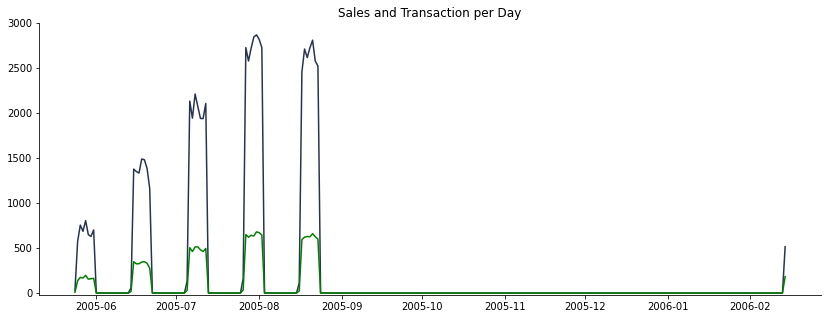

In [42]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,5)

sns.lineplot(x=dummy_date_sales.index, y=dummy_date_sales.values,ax=ax,color='#27344D')
ax.set_title('Sales and Transaction per Day')
ax.set_ylim([-20,3000])
ax.set_ylabel('Dollar USD')
sns.despine()


sns.lineplot(x=dummy_date_trans.index, y=dummy_date_trans.values,ax=ax,color='green')
ax.set_ylabel('')
sns.despine()
plt.show()

In [43]:
pd.merge(left=sales_per_day,right=trans_per_day,left_index=True,right_index=True).corr()

,amount,rental_id
amount,1.000000,0.998014
rental_id,0.998014,1.000000


Dapat dilihat bahwa Penjualan dan Transaksi memiliki tingkat korelasi yang tinggi. Hal ini merupakan hal yang normal karena semakin banyak transaksi maka semakin besar penjualan. Jika tingkat korelasi rendah maka kemungkinan ada pembelian dengan jumlah besar dalam satu kali transaksi.

### Di hari apa transaksi terbanyak dilakukan?

In [44]:
rental_copy_name = rental.copy()

In [45]:
rental_copy_name['day_name'] = rental_copy_name['payment_date'].apply(lambda x: pd.to_datetime(x).day_name())

In [46]:
rental_copy_name.groupby(['day_name']).count()['rental_id']

day_name
Friday       2272
Monday       2247
Saturday     2311
Sunday       2320
Thursday     2200
Tuesday      2463
Wednesday    2231
Name: rental_id, dtype: int64

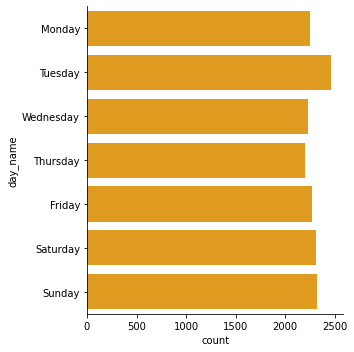

In [47]:
sns.catplot(y='day_name',data=rental_copy_name,kind='count',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],color='orange')

Tidak ada perbedaan yang terlalu mencolok. Mungkin karena hanya buka 8 hari, toko selalu ramai pengunjung

### Di jam berapa rerata jumlah transaksi terbanyak?

Dari sedikit eksplorasi

In [48]:
rental_copy_name['hour'] = rental_copy_name['rental_date'].apply(lambda x: pd.to_datetime(x).hour)

In [49]:
day_hour_trans = rental_copy_name.groupby(['payment_date','hour']).count()['rental_id']

In [50]:
day_hour_trans.head()

payment_date  hour
2005-5-24     22.0    2
              23.0    6
2005-5-25     0.0     8
              1.0     5
              2.0     3
Name: rental_id, dtype: int64

Ternyata di setiap tanggal buka, tidak didapat jumlah transaksi per jamnya. Maka dari itu dibuat dulu index dummy yang akan diisi valuenya dengan 0

In [51]:
day_hour_trans = day_hour_trans.reindex(index=pd.MultiIndex.from_product([day_hour_trans.index.levels[0], np.arange(0,25)],names=['Date', 'Hour']),fill_value=0)

In [52]:
day_hour_trans.head() # Sudah terisi 0

Date       Hour
2005-5-24  0       0
           1       0
           2       0
           3       0
           4       0
Name: rental_id, dtype: int64

Dihitung rerata per jamnya dengan cara menjumlahkan transaksi setiap jam dan membaginya dengan jumlah hari.

In [53]:
avg_trans_hour = day_hour_trans.reset_index().groupby(['Hour']).sum()/len(day_hour_trans.index.levels[0])

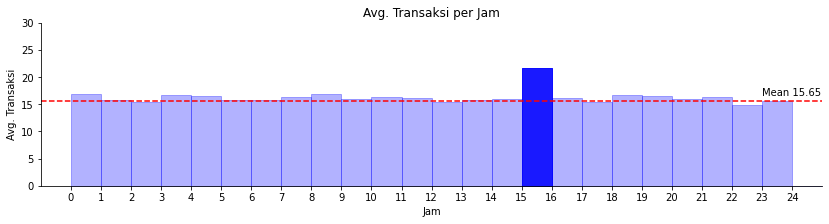

In [54]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches((14,3))
for i in avg_trans_hour.itertuples():
    if i[0] == 15:
        alpha = 0.9
    else:
        alpha = 0.3
    ax.fill_between((i[0],i[0]+1),i[-1],0,color='blue',alpha=alpha)
    
ax.axhline(y=avg_trans_hour.mean().values, color='red', linestyle='--')
ax.annotate(f'Mean {avg_trans_hour.mean().values[0]:.2f}',(23,avg_trans_hour.mean().values+1))

ax.set_xlim([-1,25])
ax.set_ylim([0,30])
ax.set_ylabel('Avg. Transaksi')
ax.set_xlabel('Jam')
ax.set_title('Avg. Transaksi per Jam')
ax.set_xticks(ticks=np.arange(0,25))
sns.despine(ax=ax)
plt.show()

Dapat dilihat bahwa setiap jam memiliki jumlah rerata transaksi yang sama. Namun pada jam 15 sampai 16, ada peningkatan rerata transaksi di jam tersebut.

In [55]:
def get_avg_trans_hour_store(store_id):
    day_hour_trans = rental_copy_name.groupby(['store_id','payment_date','hour']).count()['rental_id']
    day_hour_trans = day_hour_trans.loc[store_id]
    day_hour_trans = day_hour_trans.reindex(index=pd.MultiIndex.from_product([day_hour_trans.index.levels[0], np.arange(0,25)],names=['Date', 'Hour']),fill_value=0)
    return day_hour_trans.reset_index().groupby(['Hour']).sum()/len(day_hour_trans.index.levels[0])

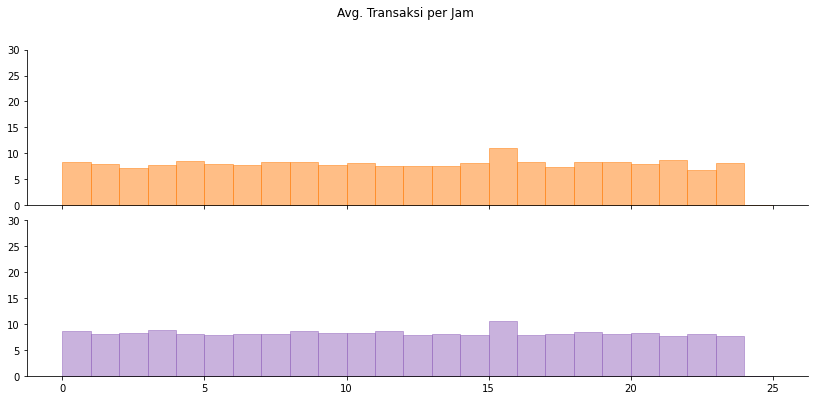

In [56]:

avg_trans_hour_1 = get_avg_trans_hour_store(1)
avg_trans_hour_2 = get_avg_trans_hour_store(2)

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_size_inches((14,6))
for i in avg_trans_hour_1.itertuples():
    ax1.fill_between((i[0],i[0]+1),i[-1],0,color='#FF7F0E',alpha=0.5)
    

for i in avg_trans_hour_2.itertuples():
    ax2.fill_between((i[0],i[0]+1),i[-1],0,color='#9467BD',alpha=0.5)

plt.subplots_adjust(hspace=0.1)
for ax in (ax1,ax2):
    sns.despine(ax=ax)
    ax.set_ylim([0,30])


fig.suptitle('Avg. Transaksi per Jam')
plt.show()

Di Toko 1 dan 2 pun terjadi hal yang sama atau tidak terlalu jauh berbeda dari trend keramaian secara keseluruhan.

In [57]:
rental.return_date

0        2005-05-26 22:04:30
1        2005-05-28 19:40:33
2        2005-06-01 22:12:39
3        2005-06-03 01:43:41
4        2005-06-02 04:33:21
                ...         
16044                    NaN
16045                    NaN
16046                    NaN
16047                    NaN
16048                    NaN
Name: return_date, Length: 16049, dtype: object

### Rangkuman
* Transaksi memiliki tingkat korelasi yang tinggi dengan penjualan
* Intensitas transaksi sama untuk semua hari (Senin-Minggu)
* Rata-rata transaksi per jam memiliki jumlah yang sama dari pukul 0 sampai pukul 24
* Ada kenaikan jumlah rata-rata transaksi pada jam 15-16.
* Kedua toko memiliki pola yang sama dengan trend keseluruhan

## Film

### Berapa banyak stock film dari Toko Sakila?

In [58]:
inv_film = pd.read_csv('data/inv_film.csv',index_col=0)

In [59]:
len(inv_film.inventory_id.unique())

4581

In [60]:
len(inv_film.film_id.unique())

958

In [61]:
len(inv_film.inventory_id.unique())/len(inv_film.film_id.unique())

4.781837160751566

Toko sakila memiki 4.581 stock film dengan 958 judul yang berbeda. Berarti rerata setiap film memiliki 4 salinan.

### Apakah stock film di toko 1 dan 2 sama?

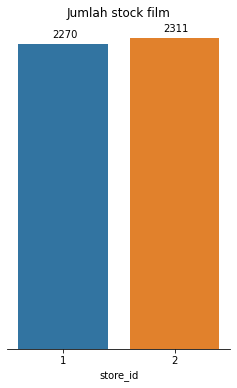

In [62]:
plt.figure(figsize=(4,6))
ax = plt.subplot(111)
sns.countplot(x='store_id',data=inv_film,ax=ax)
sns.despine(left=True,ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
n_store_1 = inv_film.groupby('store_id').count()['inventory_id'][1]
n_store_2 = inv_film.groupby('store_id').count()['inventory_id'][2]
ax.annotate(n_store_1,(-0.1,n_store_1+50))
ax.annotate(n_store_2,(0.9,n_store_2+50))
ax.set_title('Jumlah stock film')
plt.show()

Jika dilihat dari grafik di atas, toko 2 memiliki jumlah inventory yang lebih banyak daripada toko 1. Namun hanya berbeda 41 salinan saja. Bagaimana dengan jumlah judulnya?

### Apakah jumlah judul film di toko 1 dan 2 sama?

In [63]:
inv_film.groupby('store_id')['film_id'].nunique()

store_id
1    759
2    762
Name: film_id, dtype: int64

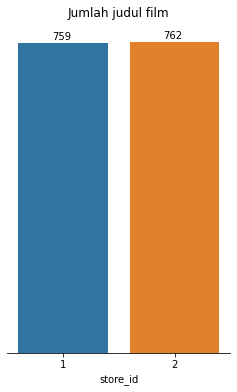

In [64]:
plt.figure(figsize=(4,6))
ax = plt.subplot(111)
sns.barplot(x=inv_film.groupby('store_id')['film_id'].nunique().index,y=inv_film.groupby('store_id')['film_id'].nunique(),ax=ax)
sns.despine(left=True,ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
n_store_1 = inv_film.groupby('store_id')['film_id'].nunique()[1]
n_store_2 = inv_film.groupby('store_id')['film_id'].nunique()[2]
ax.annotate(n_store_1,(-0.1,n_store_1+10))
ax.annotate(n_store_2,(0.9,n_store_2+10))
ax.set_title('Jumlah judul film',pad=10)
plt.show()

Ternyata sama dengan jumlah stock film, jumlah judul pada toko 2 pun lebih banyak daripada toko 1. Mungkin ada pertanyaan mengapa jika kedua jumlah judul di setiap toko dijumlah tidak sama dengan yang kita temukan tadi?\
Ini terjadi karena mungkin pada toko 1 dan toko 2 terdapat judul film yang sama, sehingga pada perhitungan totalnya hanya dibaca 1 saja.

### Berapa judul film yang unik di toko 1 dan 2?
Unik = Tidak ada di toko lainnya

In [65]:
list_film_store_1 = set(inv_film[inv_film['store_id']==1].title.unique())
list_film_store_2 = set(inv_film[inv_film['store_id']==2].title.unique())

In [66]:
unique_1 = len(list_film_store_1.difference(list_film_store_2))
unique_2 = len(list_film_store_2.difference(list_film_store_1))

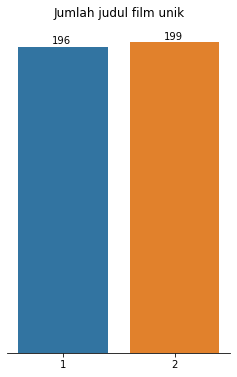

In [67]:
plt.figure(figsize=(4,6))
ax = plt.subplot(111)
sns.barplot(x=[1,2],y=[unique_1,unique_2],ax=ax)
sns.despine(left=True,ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
n_store_1 = unique_1
n_store_2 = unique_2
ax.annotate(n_store_1,(-0.1,n_store_1+2))
ax.annotate(n_store_2,(0.9,n_store_2+2))
ax.set_title('Jumlah judul film unik',pad=10)
plt.show()

In [68]:
len(list_film_store_2.intersection(list_film_store_1))

563

Ternyata pada setiap toko terdapat judul film yang tidak ada di toko lainnya. Toko 2 memiliki jumlah judul film yang unik lebih banyak dari toko, walaupun hanya terpaut 3 judul saja. Kedua toko memiliki 563 judul film yang sama. 

### Secara keseluruhan, judul film mana yang memiliki jumlah salinan terbanyak?

In [69]:
inv_film.groupby('title').count()['inventory_id'].sort_values(ascending=False).head(25)

title
ACADEMY DINOSAUR       8
HARRY IDAHO            8
GIANT TROOPERS         8
GILMORE BOILED         8
GLEAMING JAWBREAKER    8
GOODFELLAS SALUTE      8
GREATEST NORTH         8
GRIT CLOCKWORK         8
HEAVYWEIGHTS BEAST     8
BOOGIE AMELIE          8
HOBBIT ALIEN           8
HORROR REIGN           8
HUSTLER PARTY          8
INNOCENT USUAL         8
INVASION CYCLONE       8
JUGGLER HARDLY         8
GARDEN ISLAND          8
FROST HEAD             8
FORWARD TEMPLE         8
FAMILY SWEET           8
EXPENDABLE STALLION    8
DYNAMITE TARZAN        8
DOGMA FAMILY           8
DINOSAUR SECRETARY     8
DEER VIRGINIAN         8
Name: inventory_id, dtype: int64

In [70]:
sum(inv_film.groupby('title').count()['inventory_id'].sort_values(ascending=False) == 8)

72

Ternyata jumlah salinan terbanyak adalah 8 salinan dan terdapat banyak film yang memiliki salinan sebanyak 8, lebih tepatnya ada 72 film yang memiliki 8 salinan.

### Berapa rerata salinan film yang ada di toko 1 dan 2?

In [71]:
count_copy_store = inv_film.groupby(['store_id','title']).count()['inventory_id'].reset_index()

In [72]:
count_copy_store.drop(['title'],inplace=True,axis=1)

In [73]:
count_copy_store.columns = ['store_id','count_copy']

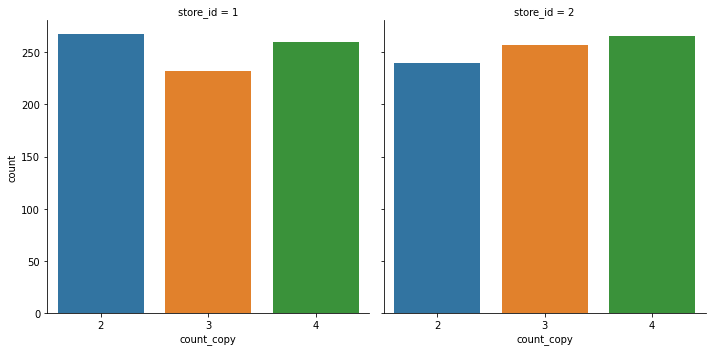

In [74]:
sns.catplot(x='count_copy',data=count_copy_store,col='store_id',kind='count')
plt.show()

In [75]:
stats, pval = mannwhitneyu(count_copy_store[count_copy_store['store_id']==1]['count_copy'],
                           count_copy_store[count_copy_store['store_id']==2]['count_copy'],
                           alternative='two-sided')

pval <= 0.05

False

Distribusi salinan dari setiap toko menyerupai distribusi uniform. Bisa dikatakan bahwa setiap toko sakila memili rerata 3 salinan untuk setiap film dan tidak ada perbedaan antara 2 toko.

### Rangkuman
* Karakteristik film dari kedua toko sakila tidak terlalu jauh berbeda.
* Setiap toko memiliki judul film unik, namun sebagian terdapat pada kedua toko.
* Di setiap toko, rerata terdapat 3 salinan untuk setiap film.

---

## Rental

### Berapa jumlah rental film yang belum kembali?

Jika dilihat pada column `return_date` terdapat beberapa NaN value.

In [76]:
rental['return_date'].isna().sum()

188

In [77]:
na_return_date = rental[rental['return_date'].isna()]

In [78]:
na_return_date.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update_x,film_id,store_id,last_update_y,...,length,replacement_cost,rating,special_features,payment_id,customer_id_payment,staff_id_payment,amount,payment_date,last_update
11491,11496.0,2006-02-14 15:16:03,2047.0,155.0,NaN,1.0,2006-02-15 21:30:53,445.0,1.0,2006-02-15 05:09:17,...,100.0,11.99,G,"{'Deleted Scenes', 'Trailers'}",4234,155,2,7.98,2006-2-14,2006-02-15 22:13:33
11536,11541.0,2006-02-14 15:16:03,2026.0,335.0,NaN,1.0,2006-02-15 21:30:53,440.0,2.0,2006-02-15 05:09:17,...,105.0,21.99,G,"{'Deleted Scenes', 'Behind the Scenes'}",9066,335,2,0.99,2006-2-14,2006-02-15 22:16:21
11558,11563.0,2006-02-14 15:16:03,1545.0,83.0,NaN,1.0,2006-02-15 21:30:53,338.0,2.0,2006-02-15 05:09:17,...,51.0,23.99,PG,"{'Commentaries', 'Deleted Scenes', 'Behind the...",2268,83,2,4.99,2006-2-14,2006-02-15 22:12:53
11572,11577.0,2006-02-14 15:16:03,4106.0,219.0,NaN,2.0,2006-02-15 21:30:53,893.0,2.0,2006-02-15 05:09:17,...,91.0,11.99,PG,{'Behind the Scenes'},5947,219,1,4.99,2006-2-14,2006-02-15 22:14:19
11588,11593.0,2006-02-14 15:16:03,817.0,99.0,NaN,1.0,2006-02-15 21:30:53,178.0,1.0,2006-02-15 05:09:17,...,115.0,25.99,G,"{'Deleted Scenes', 'Behind the Scenes'}",2687,99,1,0.99,2006-2-14,2006-02-15 22:13:00


Nilai NaN ini bisa dikatakan sebagai rental yang belum kembali. Namun juga ada beberapa NaN yang memang tidak memiliki arti karena hasil penggabungan dengan payment.

In [79]:
na_return_date.tail(2)

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update_x,film_id,store_id,last_update_y,...,length,replacement_cost,rating,special_features,payment_id,customer_id_payment,staff_id_payment,amount,payment_date,last_update
16047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14675,546,1,3.99,2005-7-30,2006-02-15 22:21:38
16048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15458,577,2,0.99,2005-5-27,2006-02-15 22:22:32


In [80]:
na_return_date = na_return_date[np.invert(na_return_date['rental_date'].isna())]

In [81]:
len(na_return_date)

183

Terdapat 183 rental yang belum dikembalikan

### Untuk setiap toko, berapa proporsi rental yang belum dikembalikan?

In [90]:
rental_clean = rental[np.invert(rental['rental_id'].isna())] # Menghilangkan data yang ada di payment saja

In [91]:
rental_clean['is_returned'] = np.invert(rental_clean['return_date'].isna())

C:\Users\MSI~1\AppData\Local\Temp/ipykernel_31888/699471657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_clean['is_returned'] = np.invert(rental_clean['return_date'].isna())


In [93]:
len(rental_clean)

16044

In [84]:
len(na_return_date)*100/len(rental_clean)

1.1406133133881824

Secara keseluruhan terdapat 1.14% rental yang belum kembali

In [96]:
store_returned = pd.crosstab(index=rental_clean['is_returned'],columns=rental_clean['store_id'])

In [97]:
store_returned

store_id,1.0,2.0
is_returned,,
False,92,91
True,7831,8030


In [115]:
nobs = store_returned.sum(axis=0).values

In [116]:
count = store_returned.loc[False].values

In [107]:
from statsmodels.stats.proportion import proportions_ztest

In [118]:
stat, pval = proportions_ztest(count,nobs,alternative='two-sided')

In [119]:
pval <= 0.05

False

In [122]:
prop_1, prop_2 = (count/nobs)*100

In [123]:
prop_1 # persentase film yang belum dikembalikan toko 1

1.1611763221002147

In [124]:
prop_2 # persentase film yang belum dikembalikan toko 2

1.1205516561999755

Toko 1 sekitar 1.16% dan toko 2 mempunyai 1.12% rental yang belum dikembalikan. Dapat terlihat bahwa toko 1 memiliki 0.04% lebih banyak rental yang belum dikembalikan, namun menurut uji test perbedaan ini tidak signifikan. Maka dari itu, dapat dikatakan toko 1 dan toko 2 tidak

### Bagaimana dengan replacement costnya?

In [152]:
rental_clean[rental_clean['is_returned']==False]['replacement_cost'].sum()

3552.1700000000005

In [147]:
rental_clean[rental_clean['is_returned']==False]['replacement_cost'].sum() > rental['amount'].sum()

False

Walaupun jumlah proporsi rental yang tidak kembali hanyak sekitar 1%, kerugian karena harus melakukan penggantian film mencapai $3.552 atau sekitar Rp51.001.569 dengan exchange rate saat ini. Hal ini mungkin yang menyebabkan toko sakila tidak bisa buka setiap waktu.

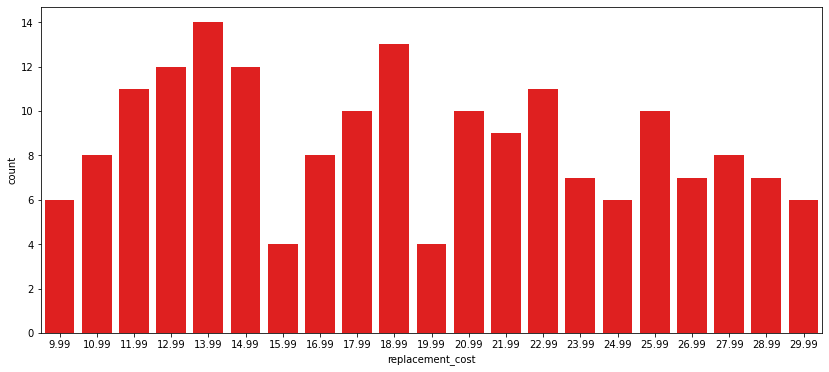

In [149]:
plt.figure(figsize=(14,6))
sns.countplot(x=rental_clean[rental_clean['is_returned']==False]['replacement_cost'],color='red')
plt.show()

Replacement cost nya pun bervariasi dari `$9.99` sampai $29.99

In [157]:
rental_clean.groupby(['is_returned','store_id']).sum()['replacement_cost'][False]

store_id
1.0    1796.08
2.0    1756.09
Name: replacement_cost, dtype: float64

Untuk setiap toko, kerugian hampir sama yaitu sekitar $1.800. Mungkin dari ini toko sakila harus mulai berbenah dalam prosedur pengembalian rental. Prosedur tersebut harus lebih ketat, atau mungkin membuat sebuah _event_ dimana pengembalian rental tidak mendapatkan denda agar para penyewa yang takut untuk mengembalikan dapat segera mengembalikan dan toko sakila terhindar dari kerugian yang lebih besar.

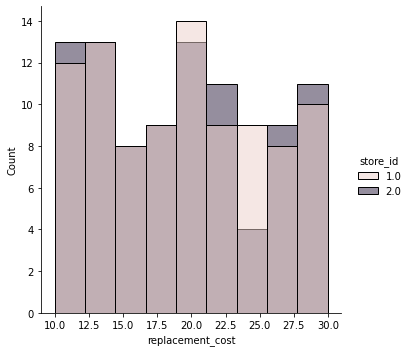

In [162]:
sns.displot(x='replacement_cost',data=na_return_date,hue='store_id',kind='hist')
plt.show()

In [163]:
stats, pval = mannwhitneyu(na_return_date[na_return_date['store_id']==1]['replacement_cost'],
                           na_return_date[na_return_date['store_id']==2]['replacement_cost'],
                           alternative='two-sided')

pval <= 0.05

False

Dapat dilihat bahwa distribusi replacement cost dari setiap toko hampir sama dan secara statistik perbedaannya pun tidak signifikan.

### Apakah pengembalian rental mempunyai korelasi dengan biaya?

In [197]:
rental_clean[['is_returned','rental_rate']].corr('spearman')

,is_returned,rental_rate
is_returned,1.000000,0.008292
rental_rate,0.008292,1.000000


In [198]:
rental_clean[['is_returned','amount']].corr('spearman')

,is_returned,amount
is_returned,1.000000,0.063304
amount,0.063304,1.000000


In [199]:
rental_clean[['is_returned','replacement_cost']].corr('spearman')

,is_returned,replacement_cost
is_returned,1.000000,0.014269
replacement_cost,0.014269,1.000000


Dapat dilihat bahwa tidak ada korelasi apapun antara pengembalian dengan biaya apapun. Berarti kecil kemungkinan bahwa penyewa sengaja menyewa untuk melakukan jual beli film.

### Bagaimana dengan proporsi rental yang melebihi batas waktu?

In [132]:
rental['return_duration'] = (pd.to_datetime(rental['return_date']) - pd.to_datetime(rental['rental_date'])).dt.days

In [173]:
rental_clean['return_duration'] = (pd.to_datetime(rental_clean['return_date']) - pd.to_datetime(rental_clean['rental_date'])).dt.days

C:\Users\MSI~1\AppData\Local\Temp/ipykernel_31888/3672012052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_clean['return_duration'] = (pd.to_datetime(rental_clean['return_date']) - pd.to_datetime(rental_clean['rental_date'])).dt.days


In [183]:
(rental_clean.return_duration > rental_clean.rental_duration).sum()

6403

In [184]:
(rental_clean.return_duration > rental_clean.rental_duration).sum()*100 / len(rental_clean)

39.90900024931439

Secara keseluruhan terdapat 6.403 atau 39.91% rental yang pengembaliannya melebihi batas waktu. Hal ini cukup banyak dan bisa merugikan toko

In [179]:
rental_clean['is_late'] = (rental_clean.return_duration > rental_clean.rental_duration)

C:\Users\MSI~1\AppData\Local\Temp/ipykernel_31888/2510211321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_clean['is_late'] = (rental_clean.return_duration > rental_clean.rental_duration)


In [185]:
store_late = pd.crosstab(index=rental_clean['is_late'],columns=rental_clean['store_id'])

In [186]:
store_late

store_id,1.0,2.0
is_late,,
False,4719,4922
True,3204,3199


In [188]:
prop_1, prop_2 = (count/nobs)*100

In [189]:
prop_1 # persentase film yang belum dikembalikan toko 1

40.439227565316166

In [190]:
prop_2 # persentase film yang belum dikembalikan toko 2

39.391700529491445

In [191]:
nobs = store_late.sum(axis=0).values
count = store_late.loc[True].values

stat, pval = proportions_ztest(count,nobs,alternative='two-sided')
pval <= 0.05

False

Dapat dilihat bahwa toko 1 memiliki proporsi keterlambatan pengembalian lebih banyak daripada toko 2, berbeda sekitar 1%. Namun hal ini tidak terlalu signifikan berdasarkan test yang dilakukan.

### Apakah durasi keterlambatan sama antara toko?

In [200]:
late_rental = rental[(rental.return_duration > rental.rental_duration)]

In [201]:
late_rental['late_duration'] = late_rental.return_duration - late_rental.rental_duration

C:\Users\MSI~1\AppData\Local\Temp/ipykernel_31888/1751903151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_rental['late_duration'] = late_rental.return_duration - late_rental.rental_duration


<Figure size 1008x432 with 0 Axes>

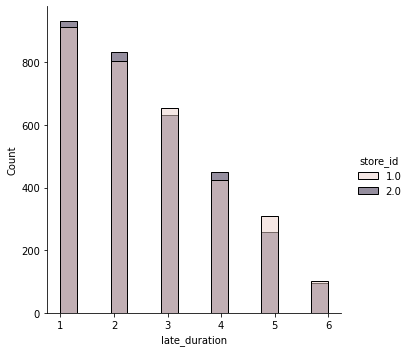

In [202]:
plt.figure(figsize=(14,6))
sns.displot(x='late_duration',data=late_rental,hue='store_id')
plt.show()

In [169]:
stats, pval = mannwhitneyu(late_rental[late_rental['store_id']==1]['return_duration'],
                           late_rental[late_rental['store_id']==2]['return_duration'],
                           alternative='two-sided')

pval <= 0.05

False

Dapat dilihat bahwa tidak ada perbedaan durasi keterlambatan yang signifikan antara kedua toko

### Apakah ada korelasi antara waktu keterlambatan dengan batas waktu?

In [203]:
rental_clean[['is_late','rental_duration']].corr('spearman')

,is_late,rental_duration
is_late,1.000000,-0.314454
rental_duration,-0.314454,1.000000


In [204]:
rental_clean[['return_duration','rental_duration']].corr('spearman')

,return_duration,rental_duration
return_duration,1.000000,0.001319
rental_duration,0.001319,1.000000


Ada korelasi lemah antara keterlambatan dengan batas waktu, semakin rendah batas waktunya maka semakin besar kemungkinan rental akan terlambat. Namun tidak ada korelasi antara waktu keterlambatan dengan batas waktu rental.

### Rangkuman
* Pada toko sakila, tedapat kerugian $1.800 karena rental yang belum/tidak kembali.
* Keterlambatan pengembalian sangat tinggi di kedua toko.
* Disarankan meninjau ulang untuk mekanisme atau prosedur dalam pengembalian rental.

---

# Staff

Sebenarnya saat melakukan analisis mengenai Store, secara tidak langsung dilakukan analisis untuk staff. Hal ini dikarenakan 1 toko hanya punya 1 staff. Maka dari itu analisis staff ini hanya sedikit.

## Tempat tinggal

In [205]:
staff.head()

,staff_id,first_name,last_name,address_id,picture,email,store_id,active,username,password,last_update,address,district,city,country
0,1,Mike,Hillyer,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Mike.Hillyer@sakilastaff.com,1,1,Mike,8cb2237d0679ca88db6464eac60da96345513964,2006-02-15 03:57:16,23 Workhaven Lane,Alberta,Lethbridge,Canada
1,2,Jon,Stephens,4,NaN,Jon.Stephens@sakilastaff.com,2,1,Jon,NaN,2006-02-15 03:57:16,1411 Lillydale Drive,QLD,Woodridge,Australia


Setiap staff berada di district yang sama dengan lokasi toko.

Performa staff sudah dapat digambarkan dengan performa toko karena 1 toko 1 staff.

### Customer yang berada di district yang sama dengan staff

In [208]:
customer = pd.read_csv('data/customer_address.csv',index_col=0)

In [210]:
customer.head()

,customer_id,store_id,first_name,last_name,address,postal_code,district,city,country
0,1,1,MARY,SMITH,1913 Hanoi Way,35200,Nagasaki,Sasebo,Japan
1,2,1,PATRICIA,JOHNSON,1121 Loja Avenue,17886,California,San Bernardino,United States
2,3,1,LINDA,WILLIAMS,692 Joliet Street,83579,Attika,Athenai,Greece
3,4,2,BARBARA,JONES,1566 Inegl Manor,53561,Mandalay,Myingyan,Myanmar
4,5,1,ELIZABETH,BROWN,53 Idfu Parkway,42399,Nantou,Nantou,Taiwan


In [211]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  599 non-null    int64 
 1   store_id     599 non-null    int64 
 2   first_name   599 non-null    object
 3   last_name    599 non-null    object
 4   address      599 non-null    object
 5   postal_code  599 non-null    int64 
 6   district     596 non-null    object
 7   city         599 non-null    object
 8   country      599 non-null    object
dtypes: int64(3), object(6)
memory usage: 46.8+ KB


In [213]:
staff['district'].values

array(['Alberta', 'QLD'], dtype=object)

In [222]:
customer['district'].apply(lambda x: x in staff['district'].values).sum()

0

In [223]:
customer['city'].apply(lambda x: x in staff['city'].values).sum()

0

In [224]:
customer['country'].apply(lambda x: x in staff['country'].values).sum()

5

Ternyata tidak ada customer yang berada di district dan city yang sama dengan staff toko sakila, pada tingkat country pun hanya ada 5 orang saja. Ini akan sedikit menyulitkan karena ketika rental tidak dikembalikan, berarti harus melakukan pengiriman lintas negara. Dari sini mungkin bisa dibuat kebijakan, peminjam harus beralamat di kota yang sama dengan toko sakila atau staff.

In [225]:
customer[customer['country']=='Canada']

,customer_id,store_id,first_name,last_name,address,postal_code,district,city,country
188,189,1,LORETTA,CARPENTER,891 Novi Sad Manor,5379,Ontario,Oshawa,Canada
409,410,2,CURTIS,IRBY,432 Garden Grove Street,65630,Ontario,Richmond Hill,Canada
435,436,1,TROY,QUIGLEY,983 Santa F Way,47472,British Colombia,Vancouver,Canada
462,463,2,DARRELL,POWER,1844 Usak Avenue,84461,Nova Scotia,Halifax,Canada
475,476,1,DERRICK,BOURQUE,1153 Allende Way,20336,Qubec,Gatineau,Canada


In [226]:
customer[customer['country']=='Australia']

,customer_id,store_id,first_name,last_name,address,postal_code,district,city,country


---

## Rangkuman

* Dapat dilihat bahwa dari data sampai 2006 ini toko sakila memiliki pola buka toko dan transaksi yang cukup aneh.
* Toko tampak buka 24 jam dalam 8 hari periode dan akan tutup selama 21 hari berikutnya.
* Kebijakan 24 jam buka ini sebenarnya tidaklah salah, namun karena pada 1 toko hanya ada 1 staff, maka shift 24 jam selama 8 hari berturut-turut tidaklah masuk akal.
* Total sales dan sales per hari dalam 1 tahun tidaklah buruk, namun karena tidak ada data profit membuat susah menganalisis performa secara menyeluruh.
* Dalam hal rental, terdapat kerugian karena ada beberapa rental yang belum kembali.
* Potensi untuk replacement costnya adalah $1.800.
* Dalam hal pengembalian rentalpun banyak yang terlambat, hampir sekitar 40%.
* Kebijakan harus dibuat untuk menurutkan tingkat keterlambatan dan mencegah adanya rental yang tidak kembali.
* Salah satu caranya adalah mensyaratkan penyewa harus berada di 1 kota yang sama dengan pegawai dan toko.
* Ini berlandaskan bahwa ternyata banyak penyewa yang berasal dari luar negeri.
* Secara keseluruhan tidak ada perbedaan tingkat performa antara kedua toko dan kedua staff.
* Memang paling akhir adalah kebijakan perusahaan harus dibenahi.

# Terima kasih